In [4]:
import os
from shutil import copyfile, rmtree

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow


import warnings; warnings.simplefilter('ignore')

import PIL
from PIL import ImageDraw

%matplotlib inline


In [5]:
data_dir = "/home/ubuntu/data/"

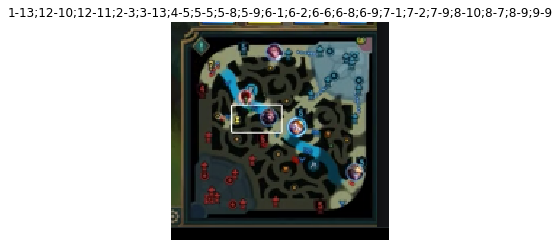

In [6]:
data = (ImageList.from_csv(data_dir+"/team", data_dir+'/full_coordinates.csv', suffix='.png')
        .split_by_rand_pct()
        .label_from_df(label_delim=' ')
        .databunch(bs=128)
        .normalize(imagenet_stats))

data.show_batch(rows=1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


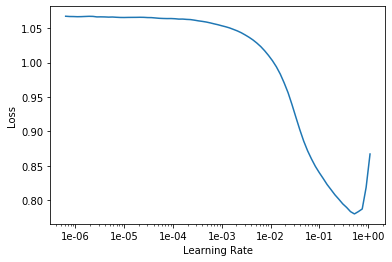

In [8]:
# learn.lr_find()
# learn.recorder.plot()

In [ ]:
# https://gilberttanner.com/blog/fastai-multi-label-image-classification

In [23]:
thresh = 0.2
acc_02 = partial(accuracy_thresh, thresh=thresh)
f_score = partial(fbeta, thresh=thresh)
learn = create_cnn(data, models.resnet50, metrics=[acc_02, f_score])
learn.callbacks = [SaveModelCallback(learn, every='improvement', mode='min', name='best')]
gc.collect()

0

In [24]:
lr = 0.05
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.183281,0.162316,0.924709,0.394471,04:34
1,0.153466,0.154144,0.925825,0.481995,04:35
2,0.142187,0.142710,0.933482,0.524259,04:33


Better model found at epoch 0 with valid_loss value: 0.16231639683246613.
Better model found at epoch 1 with valid_loss value: 0.1541440784931183.
Better model found at epoch 2 with valid_loss value: 0.14271019399166107.


In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(20, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.138603,0.148128,0.935873,0.523451,05:58
1,0.137613,0.141894,0.935692,0.524575,05:58
2,0.136348,0.140556,0.939132,0.521785,05:58
3,0.134214,0.133961,0.934219,0.550140,05:58
4,0.132704,0.133166,0.941118,0.546148,05:58
5,0.129746,0.476398,0.935646,0.540109,05:58
6,0.126675,0.127895,0.940649,0.572069,05:58
7,0.124321,0.149673,0.940913,0.576722,05:58
8,0.118432,0.127300,0.944221,0.589995,05:59
9,0.114765,0.131884,0.944878,0.609542,05:59


Better model found at epoch 0 with valid_loss value: 0.14812776446342468.
Better model found at epoch 1 with valid_loss value: 0.14189356565475464.
Better model found at epoch 2 with valid_loss value: 0.14055569469928741.
Better model found at epoch 3 with valid_loss value: 0.13396050035953522.
Better model found at epoch 4 with valid_loss value: 0.13316595554351807.
Better model found at epoch 6 with valid_loss value: 0.12789472937583923.
Better model found at epoch 8 with valid_loss value: 0.12729957699775696.
Better model found at epoch 10 with valid_loss value: 0.11428385972976685.
Better model found at epoch 11 with valid_loss value: 0.11040692031383514.
Better model found at epoch 12 with valid_loss value: 0.10832073539495468.
Better model found at epoch 18 with valid_loss value: 0.10806035995483398.
Better model found at epoch 19 with valid_loss value: 0.1076374277472496.


### Results
* learn.fit_one_cycle(10, slice(1e-5, lr/5))
* 9	0.100947	0.109149	0.946151	0.642221	05:58

In [27]:
preds = learn.get_preds(ds_type=DatasetType.Valid)

In [28]:
grid_size = 10
def draw_grid(draw, labels):
    fill = (0, 255, 255, 96)
    for l in labels:
        x = l[0] * grid_size
        y = l[1] * grid_size
        draw.rectangle((x, y, x + grid_size, y + grid_size), fill=fill)
        
def process(image):
    plt.figure()
    plt.imshow(image)
        
def draw_preds(index):
    p = preds[0][index]
    classes = [data.classes[i] for i in range(len(p)) if p[i] > thresh]
    classes = [(int(c.split("-")[0]), int(c.split("-")[1])) for c in classes]

    filename = learn.data.valid_ds.items[index]
    img = PIL.Image.open(filename)

    overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw_grid(draw, classes)
    out = PIL.Image.alpha_composite(img, overlay)

    process(out)
    filename =  filename.split("/")[-1]
    filename = data_dir+"/full/"+filename
    img = PIL.Image.open(filename)
    process(img)

In [29]:
k = 123

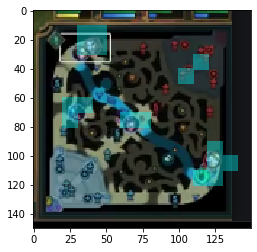

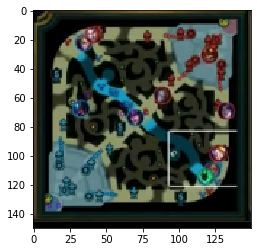

In [43]:
k += random.randint(10, 50)
draw_preds(k)

In [ ]:
learn_gen.export("~/models/predict-.pth")